In [ ]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from time import sleep
from IPython.display import clear_output
from collections import Counter

In [ ]:
#Define wind force class names
wind_force_class_names = ["No wind","Weak wind force","Middle wind force","Strong wind force"]

In [ ]:
# fun to crop img
def fn_crop_image(img_array, y_start, x_start):
    y_heigth = 60
    x_width = 110
    
    crop_image = img_array[y_start:y_start+y_heigth,x_start:x_start+x_width] # set RGB to 0 to only analyze red chanel
    return crop_image

# fun to resize img
# to do if further dimension reduction is desired
    

In [ ]:
# define data directory
DATADIR = "../data/Originals/"

# import labels
label_df = pd.read_csv("../data/labels_old_camera.csv")
label_df = label_df.rename(columns={"Unnamed: 0": "img"})

# retain only labels / img with meaningful label
label_df = label_df[label_df["wind_force"] != "0"]

# array with img names of labeled img
labeled_img = label_df["img"].to_numpy()

# create numeric wind force variable
label_df["wind_force_num"] = np.where(label_df["wind_force"] == "n", 0,
                             np.where(label_df["wind_force"] == "w", 1,
                             np.where(label_df["wind_force"] == "m", 2,
                             np.where(label_df["wind_force"] == "s", 3, -1))))


In [ ]:
#Create Training Data
training_data = []

#Set True to harmonize amount of pictures per label (multiply pictures and labels)
harmonize = False
# Get count per label value and calculate factors for harmonizing amounts
label_value_counts = label_df["wind_force_num"].value_counts()

maxLabels = label_value_counts.max()
factor0 = round(maxLabels / label_value_counts.loc[0])
factor1 = round(maxLabels / label_value_counts.loc[1])
factor2 = round(maxLabels / label_value_counts.loc[2])
factor3 = round(maxLabels / label_value_counts.loc[3])
if harmonize:
  print(f"factors for 0,1,2,3 category: {factor0,factor1,factor2,factor3}")


def create_training_data():
    for img in labeled_img:
        path = os.path.join(DATADIR, img)
        img_array = cv2.imread(os.path.join(path))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
        new_array = fn_crop_image(img_array, 250, 570)
        wind_label = label_df.loc[label_df["img"] == img, "wind_force_num"] # get label to coresponding img
        wind_label = np.ndarray.item(wind_label.to_numpy()) # convert to single scalar integer
        if harmonize:
          if wind_label == 0: #No wind
            for i in range(factor0):
              training_data.append([new_array, wind_label])
          if wind_label == 1: #Middle wind
            for i in range(factor1):
              training_data.append([new_array, wind_label])
          if wind_label == 2: #Middle wind
            for i in range(factor2):
              training_data.append([new_array, wind_label])
          if wind_label == 3: #Strong wind
            for i in range(factor3):
              training_data.append([new_array, wind_label])
        else:
          training_data.append([new_array, wind_label])
    
create_training_data()

In [ ]:
images = []
labels = []

for feature, label in training_data:
    images.append(feature)
    labels.append(label)

# mutate to np.array
np_images = np.array(images).reshape(-1, np.array(images).shape[1], np.array(images).shape[2], np.array(images).shape[3])
np_labels = np.array(labels)

In [ ]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
#import plotly.express as px
#import seaborn as sns
#sns.set()

from time import time as timer
import tarfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import visualkeras

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [ ]:
#Convert image shape and split to train and test set
label_amount = np_labels.size

print(f"np_images shape: {np_images.shape}")
np_images_red = np_images[:,:,:,0] #reduce to red channel
print(f"np_images_red shape: {np_images_red.shape}")

np_images_red_flatten = np_images_red[:label_amount,:].reshape(label_amount,-1)
print(f"np_images_red_flatten shape: {np_images_red_flatten.shape}")

#1) Split into train and test set: HEADS-UP: RANDOM_STATE set to 7 for reproducable results..
#x_train, x_test, y_train, y_test = train_test_split(np_images_red_flatten, np_labels, test_size=0.2,random_state=7)
x_train, x_test, y_train, y_test = train_test_split(np_images_red, np_labels, test_size=0.2,random_state=7) # da im NN geflatted wird
X_full, y_full = np_images_red, np_labels

print(f"np_labels shape: {np_labels.shape}")

In [ ]:
# standardize pixel-values
x_train = x_train/255
x_test = x_test/255

X_full = X_full/255


## Model Training

### Simple fully connected Neurnal Network

In [122]:
# Model 1: Simple fully connected (1 Layer)

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(60, 110)),
  tf.keras.layers.Dense(4, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model1.summary()

In [ ]:
# Model fit with all avalable data - batch_size=268              
model1.fit(x=x_train, y=y_train,
          epochs=500, batch_size=268, 
          validation_data=(x_test, y_test))

model1.evaluate(x_test,  y_test, verbose=2)

In [ ]:
# Model fit with batch_size=128
model1.fit(x=x_train, y=y_train,
          epochs=500, batch_size=128, 
          validation_data=(x_test, y_test))

model1.evaluate(x_test,  y_test, verbose=2)

In [ ]:
# Model fit with batch_size=64
model1.fit(x=x_train, y=y_train,
          epochs=500, batch_size=64, 
          validation_data=(x_test, y_test))

model1.evaluate(x_test,  y_test, verbose=2)

In [ ]:
# Model with automatical valdiation split -> peforms significantly better, but is probably overfit
model1.fit(x=X_full, y=y_full,
          epochs=100, batch_size=64, 
          validation_split=0.1)

model1.evaluate(x_test,  y_test, verbose=2)

## Model with multiple layers

In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(60, 110)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])


model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model2.summary()

In [ ]:
# Model fit with batch_size=128
model2.fit(x=x_train, y=y_train,
          epochs=500, batch_size=128, 
          validation_data=(x_test, y_test))

model2.evaluate(x_test,  y_test, verbose=2)

## Visualisierung Models

In [123]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model1.fit(x=x_train, y=y_train,
          epochs=500, batch_size=64, 
          validation_data=(x_test, y_test))



Epoch 1/500
4/4 [==============================] - 1s 64ms/step - loss: 2.0573 - accuracy: 0.2897 - val_loss: 2.2329 - val_accuracy: 0.5741
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 1.9828 - accuracy: 0.4065 - val_loss: 1.5113 - val_accuracy: 0.1481
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 1.5720 - accuracy: 0.4720 - val_loss: 1.6833 - val_accuracy: 0.5741
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6091 - accuracy: 0.5748 - val_loss: 1.2724 - val_accuracy: 0.3148
Epoch 5/500
4/4 [==============================] - 0s 11ms/step - loss: 1.4089 - accuracy: 0.4766 - val_loss: 1.3250 - val_accuracy: 0.5741
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 1.2935 - accuracy: 0.6121 - val_loss: 1.1521 - val_accuracy: 0.3333
Epoch 7/500
4/4 [==============================] - 0s 14ms/step - loss: 1.1800 - accuracy: 0.5421 - val_loss: 1.1720 - val_accuracy: 0.5741
Epoch 8/500
4/4 [===

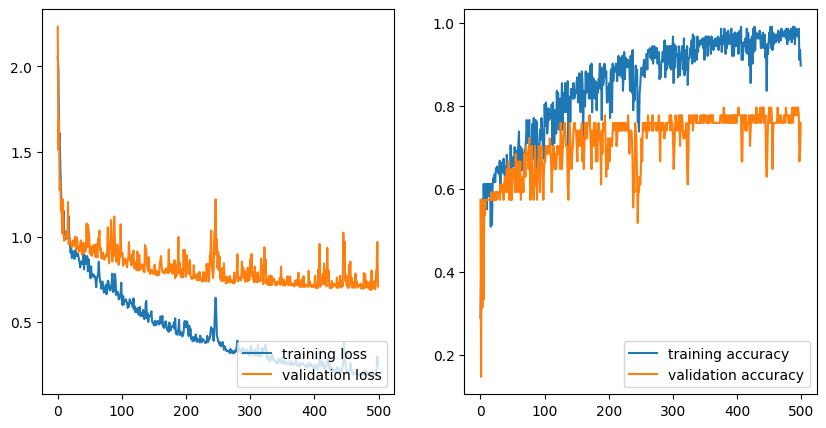

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [ ]:
model1.evaluate(x_test,  y_test, verbose=2)

true lablel:  0 ; predicted:  0 (No wind)


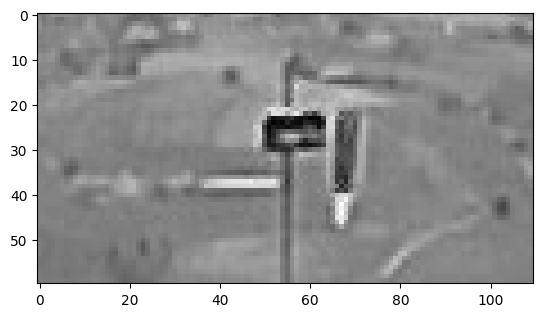

In [125]:
im_id = 0
y_pred = model1(x_test)

y_pred_most_probable = np.argmax(y_pred[im_id])
print('true lablel: ', y_test[im_id],
      '; predicted: ',  y_pred_most_probable,
      f'({wind_force_class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');

In [126]:

visualkeras.layered_view(model1)